In [3]:
import openai
import os
import urllib.request 
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import requests
import re 
import ssl  
from bs4 import BeautifulSoup
from collections import deque
from urllib.parse import urlparse
from html.parser import HTMLParser  


openai.api_key = [OpenAI API key]

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"

class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to generate a summary using OpenAI GPT
def generate_summary(text):
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=text,
        max_tokens=150,
        temperature=0.5
    )
    return response['choices'][0]['text']

def get_hyperlinks(url):
    parser = HyperlinkParser()
    try:
        with urllib.request.urlopen(url, context=ssl._create_unverified_context()) as response:
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []
    parser.feed(html)
    return parser.hyperlinks

def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        if re.search(HTTP_URL_PATTERN, link):
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    return list(set(clean_links))

# Function to crawl and generate summaries using OpenAI
def crawl_and_generate_summaries(url):
    local_domain = urlparse(url).netloc
    queue = deque([url])  # Define queue here
    seen = set([url])

    # Placeholder implementation for directory creation
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/" + local_domain + "/"):
        os.mkdir("text/" + local_domain + "/")

    if not os.path.exists("processed"):
        os.mkdir("processed")

    while queue:
        url = queue.pop()
        print(url)

        with open('text/' + local_domain + '/' + "".join(c if c.isalnum() or c in ['-', '_'] else '_' for c in url[8:]) + ".txt", "w", encoding='utf-8') as f:
            soup = BeautifulSoup(requests.get(url, verify=False).text, "html.parser") 
            text = soup.get_text()

            if "You need to enable JavaScript to run this app." in text:
                print("Unable to parse page " + url + " due to JavaScript being required")
            else:
                f.write(text)

        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl_and_generate_summaries(full_url)


https://openai.com/
https://openai.com/research/overview
https://openai.com/research/dall-e
https://openai.com/research?authors=aditya-ramesh
https://openai.com/research?topics=research
https://openai.com/research?topics=games
https://openai.com/research/gpt-4
https://openai.com/research/learning-from-human-preferences
https://openai.com/blog/deep-reinforcement-learning-from-human-preferences/#bflip
https://openai.com/research/learning-from-human-preferences#content
https://openai.com/research?authors=paul-christiano
https://openai.com/jobs
https://openai.com/interview-guide
https://openai.com/interview-guide#content
https://openai.com/commitment-to-dei
https://openai.com/commitment-to-dei#content
https://openai.com/blog/openai-residency
https://openai.com/blog/musenet
https://openai.com/research?models=musenet
https://openai.com/blog/better-language-models
https://openai.com/research/language-unsupervised
https://openai.com/research/unsupervised-sentiment-neuron
https://openai.com/res

In [4]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [5]:
import os
import pandas as pd


texts = []


for file in os.listdir("text/" + domain + "/"):

    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-', ' ').replace('_', ' ').replace('#update', ''), text))


df = pd.DataFrame(texts, columns=['fname', 'text'])

df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()


,fname,text
0,2F,2F. OpenAI CloseSearch Submit Skip to main...
1,2Falignment,2Falignment. Safety & responsibility Close...
2,2Fapi,2Fapi. Product CloseSearch Submit Skip to ...
3,2Fblog%2Fai and compute%2F%23lookingforward,2Fblog%2Fai and compute%2F%23lookingforward. ...
4,2Fblog%2Fai and compute%2F%23modern,2Fblog%2Fai and compute%2F%23modern. AI and c...


<AxesSubplot:>

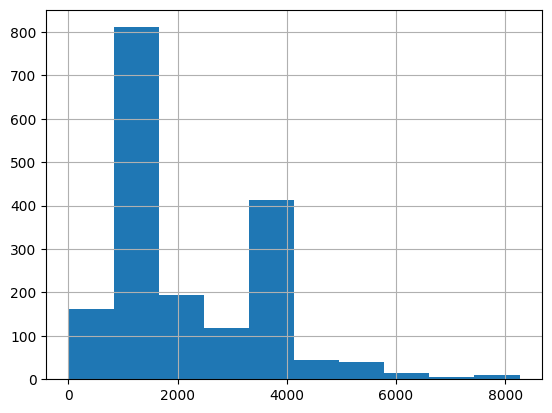

In [6]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df.n_tokens.hist()

In [7]:
max_tokens = 500

def split_into_many(text, max_tokens = max_tokens):

    
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    
    for sentence, token in zip(sentences, n_tokens):

        
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        
        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1

    
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []


for row in df.iterrows():
    
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot:>

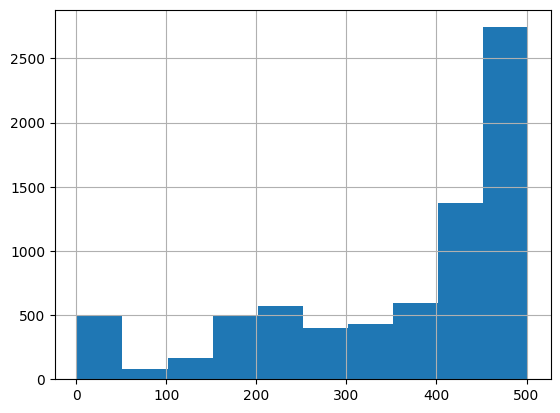

In [8]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [3]:
import openai
import pandas as pd

# Set your OpenAI API key
openai.api_key = [OpenAI API key]


urls = [
    "https://openai.com/",
    "https://openai.com/research/overview",
    
]

df = pd.DataFrame({'text': urls})

def get_embedding(text):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": text},
            ]
        )
        embedding = response["choices"][0]["message"]["content"]
        return embedding
    except Exception as e:
        print(f"Error getting embedding for text: {text}")
        print(e)
        return None

df['embeddings'] = df['text'].apply(get_embedding)

df.to_csv('processed/embeddings.csv')

df.head()


Error getting embedding for text: https://openai.com/
Rate limit reached for gpt-3.5-turbo in organization org-7Vc2QBSfuK0C4mJ5JxjphRvl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.
Error getting embedding for text: https://openai.com/research/overview
Rate limit reached for gpt-3.5-turbo in organization org-7Vc2QBSfuK0C4mJ5JxjphRvl on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.


,text,embeddings
0,https://openai.com/,None
1,https://openai.com/research/overview,None


In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval

df = pd.read_csv('processed/embeddings.csv', index_col=0)

df['embeddings'].fillna('[]', inplace=True)

# Apply literal_eval to convert string representations to lists and then convert to NumPy arrays
df['embeddings'] = df['embeddings'].apply(lambda x: np.array(literal_eval(x)))

print(df.head())


                                   text embeddings
0                   https://openai.com/         []
1  https://openai.com/research/overview         []


In [8]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """
    print("Question:", question)


    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    print("Embeddings:", q_embeddings)

    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    for i, row in df.sort_values('distances', ascending=True).iterrows():
       
        cur_len += row['n_tokens'] + 4

        if cur_len > max_len:
            break
        returns.append(row["text"])

    context = "\n\n###\n\n".join(returns)
    print("Generated Context:", context)
    return context


In [7]:
def answer_question(
    df,
    question="What day is it?",
    debug=True,
    model="text-davinci-003",
    max_len=300,
    size=5,
    stop_sequence=None
):
    context = create_context(question, df, max_len=max_len, size=size)

    openai.api_key = [OpenAI API Key]

    response = openai.Completion.create(
        model=model,
        prompt=context,
        max_tokens=max_len,
        n=size,
        stop=stop_sequence
    )


    if debug:
        print(response)

    responses = [item['choices'][0]['text'] for item in response['choices']]
    return responses
